<font size="7">Thesis file</font>
<br>

</font>

<font size="6">1. Install necessities</font>
<br>



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import csv
import imblearn
import numpy as np

import os
import seaborn as sns
from sklearn import metrics
from collections import Counter
from matplotlib import pyplot
from numpy import where
from sklearn import datasets
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
import gc
from imblearn.over_sampling import RandomOverSampler
!pip install pandas plotnine
import warnings
warnings.filterwarnings('ignore')
#from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_histogram
from sklearn.model_selection import cross_val_predict
from scipy import stats
from scipy.stats import wilcoxon
from sys import path




[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


<font size="6">2. Load and prepare data </font>
<br>



In [2]:
df = pd.read_csv("ESS10.csv", low_memory = False)

In [3]:
##Only include relevant variables
df_relevant_vars = df[['cntry', 'agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp']].copy()
df_relevant_vars.stfmjob.count()

18060

<font size="4"> Note: df_relevant_vars includes only the vars that are used in this study, it leaves out all other variables assesed in the ESS.</font>

<font size="6">
    2a. Missing values

In [4]:
##Delete missing values from satisfied with job
values = [55, 66, 77, 88, 99]
df_SF_complete = df_relevant_vars[df_relevant_vars.stfmjob.isin(values) == False]
print('Individuals missing satisfaction score:', df_relevant_vars.stfmjob.count() - df_SF_complete.stfmjob.count(), 
     '\nRemaining = ', df_SF_complete.stfmjob.count()) 

Individuals missing satisfaction score: 8149 
Remaining =  9911


In [5]:
##General missing values 33, 55, 66, 77, 88, 99 set to NaN
for col in['hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 'wrkhome', 
           'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
            'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
           'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 'colscrn' ,'colphone', 'colcom', 'c19spwrk', 'c19mcwrk','mcwrkhom']:
    df_SF_complete.loc[df_SF_complete[col] >= 33, col] = np.nan
for col in['agea']:
    df_SF_complete.loc[df_SF_complete[col] >= 999, col] = np.nan

<font size="4"> Note: df_SF_complete made below only includes the individuals that have data for job satisfaction

In [6]:
##General missing values 55, 66, 77, 88, 99 set to NaN
for col in['uemp3m', 'uemp12m','uemp5yr', 'emplrel','hincfel', 'gndr', 'trdawrk',
           'jbprtfp', 'pfmfdjba', 'dcsfwrka', 'c19wplch', 'manhlp',  'colhlp', 
           'colscrn']:
    df_SF_complete.loc[df_SF_complete[col] >= 6, col] = np.nan

In [7]:
0.6 * df_SF_complete.stfmjob.count()

5946.599999999999

In [8]:
##Drop columns if more than 60% of data is missing. This is the case for: colscrn, u
drop_cols = []
for col in ['cntry', 'agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    if df_SF_complete[col].isna().sum() >= 0.6 * df_SF_complete.stfmjob.count():
        drop_cols.append(col)
        
print('the columns that are removed due to this', drop_cols)
print(df_SF_complete.head())



the columns that are removed due to this ['colscrn', 'uemp12m', 'uemp5yr', 'c19wplch', 'colscrn']
  cntry  agea  hinctnta  eisced  hhmmb  eduyrs  sclmeet  wrkhome  c19whome  \
1    BG  43.0       NaN     6.0    4.0    16.0      7.0      1.0       2.0   
2    BG  50.0       7.0     7.0    1.0    16.0      4.0      4.0       NaN   
3    BG  51.0       6.0     4.0    3.0    11.0      4.0      6.0       NaN   
4    BG  70.0       4.0     7.0    2.0    17.0      4.0      6.0       NaN   
7    BG  48.0       4.0     4.0    2.0    12.0      3.0      6.0       NaN   

   wrklong  ...  emplrel  hincfel  gndr  trdawrk  jbprtfp  pfmfdjba  dcsfwrka  \
1      6.0  ...      3.0      1.0   1.0      4.0      3.0       3.0       3.0   
2      6.0  ...      3.0      2.0   2.0      4.0      NaN       NaN       1.0   
3      NaN  ...      1.0      3.0   2.0      3.0      3.0       3.0       1.0   
4      NaN  ...      1.0      3.0   1.0      5.0      5.0       3.0       1.0   
7      NaN  ...      1.0    

In [9]:
##count NaN per row
missing = []
for i in range(len(df_SF_complete.index)):
    value = (df_SF_complete.iloc[i].isnull().sum())
    missing.append(value)
df_SF_complete['missing'] = missing
df_SF_complete.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,hincfel,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing
1,BG,43.0,NaN,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,1.0,4.0,3.0,3.0,3.0,2.0,NaN,3.0,10
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,NaN,6.0,...,2.0,2.0,4.0,NaN,NaN,1.0,NaN,NaN,2.0,12
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,NaN,NaN,...,3.0,2.0,3.0,3.0,3.0,1.0,NaN,2.0,2.0,10
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,NaN,NaN,...,3.0,1.0,5.0,5.0,3.0,1.0,NaN,2.0,1.0,8
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,NaN,NaN,...,3.0,1.0,3.0,3.0,3.0,1.0,NaN,1.0,1.0,11


In [10]:
##Delete individuals with XX amount of missing values
df_missing_deleted = df_SF_complete[df_SF_complete.missing <= 21].copy()
df_missing_deleted.missing.count()
print('There were:', 9911, 'individuals',
    '\nIndividuals missing too many values:', 9911 - df_missing_deleted.missing.count(),
     '\nRemaing individuals:', df_missing_deleted.missing.count())

There were: 9911 individuals 
Individuals missing too many values: 759 
Remaing individuals: 9152


In [11]:
df_missing_deleted.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,hincfel,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing
1,BG,43.0,NaN,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,1.0,4.0,3.0,3.0,3.0,2.0,NaN,3.0,10
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,NaN,6.0,...,2.0,2.0,4.0,NaN,NaN,1.0,NaN,NaN,2.0,12
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,NaN,NaN,...,3.0,2.0,3.0,3.0,3.0,1.0,NaN,2.0,2.0,10
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,NaN,NaN,...,3.0,1.0,5.0,5.0,3.0,1.0,NaN,2.0,1.0,8
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,NaN,NaN,...,3.0,1.0,3.0,3.0,3.0,1.0,NaN,1.0,1.0,11


<font size="4"> Note: df_missing_deleted only includes individuals that have enough data on all variables. The columns containing too few participants are already deleted here. 

In [12]:
#Bereken wat mode is per kolom
for col in ['cntry', 'agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    print(df_missing_deleted[col].value_counts().idxmax())

##leftover van hoe ik missing verving met mode. df5['sclmeet'].fillna(4.0, inplace=True)

BG
41.0
8.0
4.0
2.0
12.0
4.0
6.0
3.0
5.0
5.0
3.0
8.0
1.0
3.0
7.0
3.0
7.0
10.0
0.0
1.0
1.0
3.0
3.0
7.0
3.0
3.0
0.0
8
2.0
2.0
2.0
1.0
2.0
2.0
3.0
3.0
3.0
1.0
1.0
1.0
1.0
3.0


In [13]:
#bereken wat mean is per kolom
for col in ['agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    print(df_missing_deleted[col].mean())
    

44.56580971215118
6.5839339536102734
4.720407715914073
2.699090809508161
13.996006212558243
4.62964587216314
4.862742944987373
2.539609644087256
4.276417607509831
4.1500894911787265
2.4158937076961644
6.912729498164015
2.268187952398479
2.9504962478818686
5.951435145936781
4.410686095931998
4.770424242424243
8.41019955654102
4.983875031494079
3.105354258019848
2.0863710239145576
3.1569713758079407
4.060595446584939
4.524504084014002
3.120066969624492
2.7954574783843076
5.46426073576724
7.473229895104895
1.699824137173005
1.6842105263157894
1.6085200146896805
1.1133625410733845
1.8912589334799341
1.5157342657342658
3.023225241016652
2.7187386294724076
2.277310924369748
1.6977738787147714
1.4675262655205348
1.6905802379218258
1.5683327507864384
3.1569713758079407


<font size="4"> Note: Every other missing value is replaced by its mode (Quintero et al., compared the missing values)


In [14]:
#Missing values vervangen met MODE
for col in ['agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom','stfmjob', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']:
    df_missing_deleted[col].fillna(df_missing_deleted[col].value_counts().idxmax(), inplace=True)

print(df_missing_deleted.head())
df_final = df_missing_deleted.copy()

##This is also appropriate for income, since income is also made ordinal. 

  cntry  agea  hinctnta  eisced  hhmmb  eduyrs  sclmeet  wrkhome  c19whome  \
1    BG  43.0       8.0     6.0    4.0    16.0      7.0      1.0       2.0   
2    BG  50.0       7.0     7.0    1.0    16.0      4.0      4.0       3.0   
3    BG  51.0       6.0     4.0    3.0    11.0      4.0      6.0       3.0   
4    BG  70.0       4.0     7.0    2.0    17.0      4.0      6.0       3.0   
7    BG  48.0       4.0     4.0    2.0    12.0      3.0      6.0       3.0   

   wrklong  ...  hincfel  gndr  trdawrk  jbprtfp  pfmfdjba  dcsfwrka  \
1      6.0  ...      1.0   1.0      4.0      3.0       3.0       3.0   
2      6.0  ...      2.0   2.0      4.0      3.0       3.0       1.0   
3      5.0  ...      3.0   2.0      3.0      3.0       3.0       1.0   
4      5.0  ...      3.0   1.0      5.0      5.0       3.0       1.0   
7      5.0  ...      3.0   1.0      3.0      3.0       3.0       1.0   

   c19wplch  manhlp  colhlp  missing  
1       2.0     1.0     3.0       10  
2       1.0     1.0 

<font size="6"> 2b Prepare job satisfaction</font>
<br>

In [15]:
##Divide job satisfaction into 4 categories. 
satisfaction = []
for i in df_final.stfmjob:
    if i <=4:
        satisfaction.append(1)
    if i == 5:
        satisfaction.append(2)
    if i == 6 or i == 7:
        satisfaction.append(3)
    if i >= 8 and i <= 10:
        satisfaction.append(4)
df_final['satisfaction'] = satisfaction
df_final.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing,satisfaction
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,4.0,3.0,3.0,3.0,2.0,1.0,3.0,10,4
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,2.0,4.0,3.0,3.0,1.0,1.0,1.0,2.0,12,2
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,2.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,10,3
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,1.0,5.0,5.0,3.0,1.0,1.0,2.0,1.0,8,1
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,11,3


<font size="4"> df_final is final dataframe

In [16]:
data = df_final
data.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,gndr,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,missing,satisfaction
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,1.0,4.0,3.0,3.0,3.0,2.0,1.0,3.0,10,4
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,2.0,4.0,3.0,3.0,1.0,1.0,1.0,2.0,12,2
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,2.0,3.0,3.0,3.0,1.0,1.0,2.0,2.0,10,3
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,1.0,5.0,5.0,3.0,1.0,1.0,2.0,1.0,8,1
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,11,3


<font size="6">3. Statistics

In [71]:
#1. divide age into 4 categories, gender into 2. 
age = []
for i in df_final.agea:
    if i <= 25:
        age.append('18-25')
    if i >= 26 and i <= 35:
        age.append('26-35')
    if i >= 36 and i <= 50:
        age.append('36-50')
    if i >= 51 and i <= 70:
        age.append('51-70')
    if i >= 71:
        age.append('70+')

df_final['age'] = age
        
#2. Divide gender    
gender = []
for i in df_final.gndr:
    if i == 1:
        gender.append('male')
    if i ==2:
        gender.append('female')
df_final['gender'] = gender

country = df_final['cntry'].copy()
df_final['country'] = country


#3. divide team feeling
team_feeling = []
for i in df_final.teamfeel:
    if i <=4:
        team_feeling.append(1)
    if i == 5:
        team_feeling.append(2)
    if i == 6 or i == 7:
        team_feeling.append(3)
    if i >= 8 and i <= 10:
        team_feeling.append(4)


df_final['team feeling'] = team_feeling

#4. divide support
manager_support = []
for i in df_final.mansupp:
    if i <=4:
        manager_support.append(1)
    if i == 5:
        manager_support.append(2)
    if i == 6 or i == 7:
        manager_support.append(3)
    if i >= 8 and i <= 10:
        manager_support.append(4)


df_final['manager support'] = manager_support


##5.Rescale income feeling. This way lower scores indicate lower satisfaction with income
income_feeling = []
for i in df_final.hincfel:
    if i == 4:
        income_feeling.append(1)
    if i == 3:
        income_feeling.append(2)
    if i == 2:
        income_feeling.append(3)
    if i == 1:
        income_feeling.append(4)

        
df_final['income feeling'] = income_feeling

#6. tired after work rename
tired = []
for i in df_final.trdawrk:
    if i == 1.0:
        tired.append(1)
    if i == 2.0:
        tired.append(2)
    if i == 3.0:
        tired.append(3)
    if i == 4.0:
        tired.append(4)
    if i == 5.0:
        tired.append(5)
        
df_final['tired after work'] = tired

#7. manager help rename
man_help = []
for i in df_final.manhlp:
    if i == 1.0:
        man_help.append(1)
    if i == 2.0:
        man_help.append(2)
    if i == 3.0:
        man_help.append(3)
    if i == 4.0:
        man_help.append(4)


df_final['manager help'] = man_help


#8. divide remote facilitation
remote_facilitation = []
for i in df_final.mcwrkhom:
    if i <=4:
        remote_facilitation.append(1)
    if i == 5:
        remote_facilitation.append(2)
    if i == 6 or i == 7:
        remote_facilitation.append(3)
    if i >= 8 and i <= 10:
        remote_facilitation.append(4)


df_final['remote facilitation'] = remote_facilitation

work_extra = []
for i in df_final.wrkextra:
    if i <=4:
        work_extra.append(1)
    if i == 5:
        work_extra.append(2)
    if i == 6 or i == 7:
        work_extra.append(3)
    if i >= 8 and i <= 10:
        work_extra.append(4)


df_final['work extra'] = work_extra




Text(0, 0.5, 'Percentage')

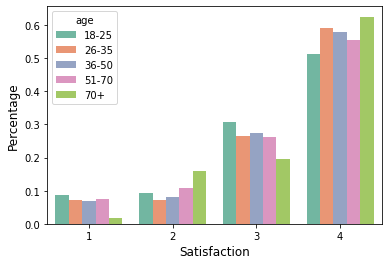

In [18]:
df = df_final
x, y, hue = "satisfaction", "proportion", "age"
hue_order = ['satisfaction']

plot_age = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = 'Set2'))

plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

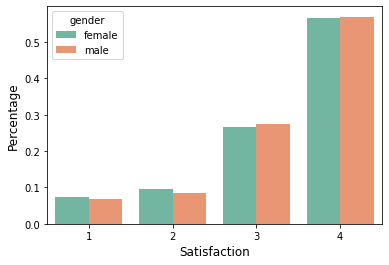

In [19]:
df = df_final
x, y, hue = "satisfaction", "proportion", "gender"
hue_order = ['satisfaction']

plot_gender = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))

plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

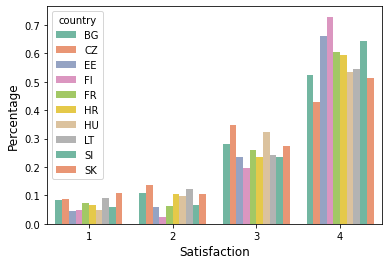

In [20]:
x, y, hue = "satisfaction", "proportion", "country"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

<font size="6">
    3. Split train and test

In [21]:
##Split data into train and test
features = ['agea','hinctnta','eisced',  'hhmmb', 'eduyrs', 'sclmeet', 
                       'wrkhome', 'c19whome', 'wrklong', 'wrkresp', 'c19whacc', 
                       'mansupp','manwrkpl', 'manspeak', 'manscrn', 'manphone',
                       'mancom','teamfeel','wrkextra', 'colprop', 'colspeak', 
                       'colscrn', 'colphone', 'colcom', 'c19spwrk', 'c19mcwrk',
                       'mcwrkhom', 'uemp3m', 'uemp12m','uemp5yr', 'emplrel',
                       'hincfel', 'gndr', 'trdawrk','jbprtfp', 'pfmfdjba', 'dcsfwrka', 
                       'c19wplch', 'manhlp',  'colhlp', 'colscrn']
target = ['satisfaction']
X = data[features]
y = data[target]
test_size = 0.2
X_train, X_test_final, y_train, y_test_final = train_test_split(X, y, test_size = test_size, random_state =0)
#sc = StandardScaler()
data.head()

,cntry,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,...,satisfaction,age,gender,country,team feeling,manager support,income feeling,tired after work,manager help,remote facilitation
1,BG,43.0,8.0,6.0,4.0,16.0,7.0,1.0,2.0,6.0,...,4,36-50,male,BG,4,4,4,4,1,4
2,BG,50.0,7.0,7.0,1.0,16.0,4.0,4.0,3.0,6.0,...,2,36-50,female,BG,3,4,3,4,1,2
3,BG,51.0,6.0,4.0,3.0,11.0,4.0,6.0,3.0,5.0,...,3,51-70,female,BG,4,4,2,3,2,1
4,BG,70.0,4.0,7.0,2.0,17.0,4.0,6.0,3.0,5.0,...,1,51-70,male,BG,3,1,2,5,2,1
7,BG,48.0,4.0,4.0,2.0,12.0,3.0,6.0,3.0,5.0,...,3,36-50,male,BG,4,4,2,3,1,1


In [22]:
print(np.shape(X_test_final))
print(np.shape(y_test_final))
print(np.shape(X_train))
print(np.shape(y_train))

(1831, 41)
(1831, 1)
(7321, 41)
(7321, 1)


<font size="6">
   4.  Oversampling

In [23]:
##Oversampling:
#probeer het ook een keer met undersampling
#kijk of je aan het overfitten bent. (= overal majority voorspellen)
print("Before oversampling and setting seed", Counter(data.satisfaction))
print('Before oversampling, after train test split', Counter(y_train.satisfaction))
print('testdata', Counter(y_test_final.satisfaction))
oversample = RandomOverSampler(sampling_strategy = 'all')
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
data_oversampled = X_train_oversampled.copy()
data_oversampled['y_train_oversampled'] = y_train_oversampled.copy()
print("After", Counter(data_oversampled.y_train_oversampled))

Before oversampling and setting seed Counter({4: 5195, 3: 2469, 2: 835, 1: 653})
Before oversampling, after train test split Counter({4: 4113, 3: 2016, 2: 672, 1: 520})
testdata Counter({4: 1082, 3: 453, 2: 163, 1: 133})
After Counter({4: 4113, 2: 4113, 3: 4113, 1: 4113})


#Use these when you only want 10% of all oversampled train data
X_10p_train_oversampled = X_train_oversampled.sample(frac = 0.1, random_state = 2)
y_10p_train_oversampled = y_train_oversampled.sample(frac = 0.1, random_state = 2)
traindata_10p_oversample = X_10p_train_oversampled.copy()
traindata_10p_oversample['y_10p_train_oversampled'] = y_10p_train_oversampled.copy()

df = traindata_10p_oversample.copy()

Using the randomstate in the above cell ensures I get the same sample everytime

In [24]:
#use this if you want all oversampled traindata
df = data_oversampled

<font size="6."> 5. Functions ordinal classification</font>
<br>



<font size="6"> 5a. Download functions</font>
<br>
Make sure you have donwloaded the file from the orca package prior to using the functions blow. See: https://github.com/ayrna/orca-python/blob/master/doc/spanish_user_manual.md

In [25]:
!make

make -e -C classifiers/libsvmRank/python
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
python setup.py build_ext --inplace && rm -f redsvm.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/libsvmRank/python'
make -e -C classifiers/svorex
make[1]: Entering directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'
python setup.py build_ext --inplace && rm -f svorex.cpp && rm -Rf build
running build_ext
make[1]: Leaving directory '/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/classifiers/svorex'


In [26]:
!python config.py with configurations/single_test.json seed=12345 -l ERROR


###############################
	Running Experiment
###############################

Running tae dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previou


Running balance-scale dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/CloudS


Running contact-lenses dataset
--------------------------
Running SVMOP ...
  Running Partition 0
  Running Partition 1
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 2
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 3
/Users/jolijneikelboom/Library/CloudStorage/OneDrive-Persoonlijk/Tilburg/Thesis/results.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = previous_df.append(df)
  Running Partition 4
/Users/jolijneikelboom/Library/Cloud

In [27]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [28]:
X_train_oversampled.isnull().values.any()

False

<font size="6">5b. Apply functions</font>
<br>



<font size="5">
    5.b.1. CSV1V1 
<font size="3">    
    Why use neg_mean_absolute_error: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [29]:
param_grid = {'estimator__C': [1], 'estimator__gamma': [0.01]}
model = SVC(decision_function_shape = 'ovo')
ovo = OneVsOneClassifier(model)
ovo_gscv = GridSearchCV(ovo, param_grid, scoring = 'neg_mean_absolute_error', return_train_score = True, cv = 4, verbose = 3)
ovo_gscv.fit(X_train_oversampled, y_train_oversampled) #je fit hem op de oversamplede data

print(ovo_gscv.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END ..........estimator__C=1, estimator__gamma=0.01; total time=  55.6s
[CV 2/4] END ..........estimator__C=1, estimator__gamma=0.01; total time=  50.7s
[CV 3/4] END ..........estimator__C=1, estimator__gamma=0.01; total time=  39.2s
[CV 4/4] END ..........estimator__C=1, estimator__gamma=0.01; total time=  41.1s
{'estimator__C': 1, 'estimator__gamma': 0.01}


In [30]:
#ovo_best = ovo(param_grid = {'estimator__C': 10, 'estimator__gamma': 0.01,'estimator__kernel': 'rbf'}
ovo_gscv_predictions = ovo_gscv.predict(X_test_final) 
ovo_gscv_df = X_test_final.copy()
ovo_gscv_df.insert(41, 'Actual', y_test_final, True)
ovo_gscv_df.insert(41, 'Predicted', ovo_gscv_predictions, True)

list_true_scores = list(ovo_gscv_df['Actual'])
list_ovo_gscv_predicted = list(ovo_gscv_df['Predicted'])

ovo_gscv_df.head()

,agea,hinctnta,eisced,hhmmb,eduyrs,sclmeet,wrkhome,c19whome,wrklong,wrkresp,...,trdawrk,jbprtfp,pfmfdjba,dcsfwrka,c19wplch,manhlp,colhlp,colscrn,Predicted,Actual
6190,30.0,10.0,7.0,2.0,17.0,6.0,2.0,1.0,4.0,5.0,...,3.0,2.0,1.0,3.0,2.0,1.0,1.0,1.0,4,4
7096,47.0,7.0,4.0,4.0,13.0,6.0,3.0,3.0,5.0,5.0,...,4.0,4.0,4.0,3.0,1.0,1.0,1.0,3.0,1,3
17615,33.0,8.0,4.0,1.0,13.0,4.0,6.0,3.0,6.0,1.0,...,3.0,4.0,3.0,1.0,1.0,2.0,2.0,3.0,4,3
9846,17.0,10.0,2.0,3.0,12.0,7.0,6.0,3.0,4.0,6.0,...,3.0,3.0,1.0,1.0,1.0,1.0,1.0,3.0,4,4
1094,41.0,9.0,4.0,6.0,12.0,6.0,5.0,3.0,4.0,3.0,...,3.0,3.0,2.0,1.0,1.0,2.0,1.0,3.0,4,3


In [31]:
print(y_train.value_counts())
print(y_train_oversampled.value_counts())
print(y_test_final.value_counts())

satisfaction
4               4113
3               2016
2                672
1                520
dtype: int64
satisfaction
1               4113
2               4113
3               4113
4               4113
dtype: int64
satisfaction
4               1082
3                453
2                163
1                133
dtype: int64


In [32]:
ovo_gscv_true = ovo_gscv_df.Actual
ovo_gscv_predicted = ovo_gscv_df.Predicted

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

print('Mae SCV1V1 after gridsearch', mae(ovo_gscv_true, ovo_gscv_predicted))
print('The best estimators:', ovo_gscv.best_estimator_)
mae_ovo_gscv = mae(ovo_gscv_true, ovo_gscv_predicted)

Mae SCV1V1 after gridsearch 0.6231567449481158
The best estimators: OneVsOneClassifier(estimator=SVC(C=1, decision_function_shape='ovo',
                                 gamma=0.01))


[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


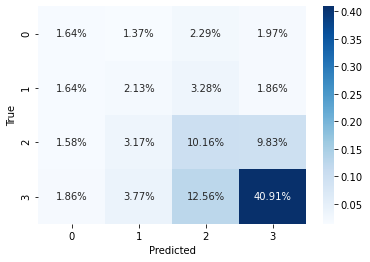

In [33]:
##CM with percentages
ovo_cf_matrix = confusion_matrix(ovo_gscv_true, ovo_gscv_predicted)
##CM with Percentages
ovo_ax = sns.heatmap(ovo_cf_matrix/np.sum(ovo_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
print(ovo_ax.set(xlabel='Predicted', ylabel='True'))

In [34]:
true_scores = ovo_gscv_df.Actual.copy()
print(mae(true_scores, ovo_gscv_predictions))

0.6231567449481158


In [35]:
zero_one_loss(true_scores, ovo_gscv_predictions)

0.45166575641725837

In [36]:
true_scores = ovo_gscv_df.Actual.copy()
print(len(true_scores))

1831


<font size="5">
    5.b.2. SVMOP

In [37]:
path.append('classifiers')
svmopModule = __import__("OrdinalDecomposition")
svmop= svmopModule.OrdinalDecomposition

In [38]:
parameter_list_C = [0.01, 0.1, 1, 10]
parameter_list_Gamma = [0.01, 0.1, 1, 10]

kf = KFold(n_splits=4, random_state=None, shuffle=False)


for C in parameter_list_C:
    for G in parameter_list_Gamma: #Hier gaat die dus voor de value van C, over elk van G. 
        print(f'C is nu: {C}, G is nu {G}')
        svmop_gscv = svmop(dtype = 'ordered_partitions', 
                              decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': C,
                                           'gamma':G, 
                                           'probability':True})
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            svmop_gscv_fit = svmop_gscv.fit(X_train, y_train)
            svmop_gscv_predictions = svmop_gscv.predict(X_test)
            real_scores_svmop = list(y_test['satisfaction'])
            mae_in_between = mae(real_scores_svmop, svmop_gscv_predictions)
            mae_fold += mae_in_between
            print(mae_in_between)
        print('belonging mae is:', mae_fold /4)
    

In [39]:
svmop_best = svmop(dtype = 'ordered_partitions', 
                               decision_method = 'frank_hall', 
                               base_classifier = 'sklearn.svm.SVC', 
                               parameters={'C': 1,
                                           'gamma': 0.01, 
                                           'probability':True})
svmop_best.fit(X_train_oversampled, y_train_oversampled)
svmop_best_predictions = svmop_best.predict(X_test_final)



[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


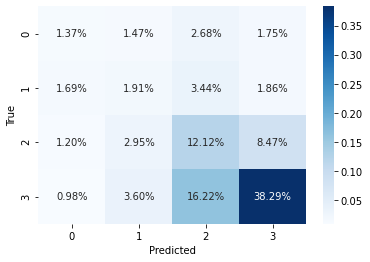

In [40]:
svmop_cf_matrix = confusion_matrix(true_scores, svmop_best_predictions)

svmop_ax = sns.heatmap(svmop_cf_matrix/np.sum(svmop_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
print(svmop_ax.set(xlabel='Predicted', ylabel='True'))

In [41]:
print('mae is', mae(true_scores, svmop_best_predictions))
print('mze is', zero_one_loss(true_scores, svmop_best_predictions))

mae is 0.6111414527580558
mze is 0.46313489896231563


<font size="5">
    5.b.3. SVOREX

In [42]:
path.append('classifiers')
svorexModule = __import__("SVOREX")
svorex= svorexModule.SVOREX

In [43]:
valuesC = [0.01, 0.1, 1, 10]
valuesK = [0.01, 0.1, 1, 10]

#SVOREX with selfmade gridsearchCV because regular gridsearch CV takes highest of fold.
for C in valuesC:
    for K in valuesK: 
        print(f'C is nu: {C}, K is nu {K}')
        svorex_gscv = svorex(c = C, k = K)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            svorex_gscv_fit = svorex_gscv.fit(X_train, y_train)
            svorex_gscv_predictions = svorex_gscv.predict(X_test)
            real_scores_svorex = list(y_test['satisfaction'])
            mae_fold += mae(y_test, svorex_gscv_predictions)
            print(mae(y_test, svorex_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )
        

svorex_best_fit = svorex_best.fit(X_train_oversampled, y_train_oversampled)

In [44]:
svorex_best = svorex(c = 0.1)
svorex_best.fit(X_train_oversampled, y_train_oversampled)
svorex_best_predictions = svorex_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


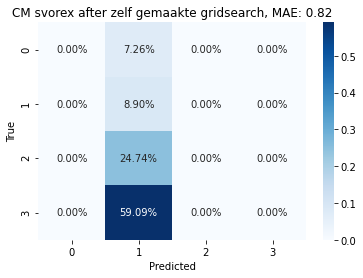

In [46]:
svorex_cf_matrix = confusion_matrix(y_test_final, svorex_best_predictions)
##CM with Percentages
svorex_new = sns.heatmap(svorex_cf_matrix/np.sum(svorex_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
svorex_new.set_title('CM svorex after zelf gemaakte gridsearch, MAE: 0.82')
print(svorex_new.set(xlabel='Predicted', ylabel='True'))

In [47]:
print('mae is', mae(y_test_final, svorex_best_predictions))
print('mze is', zero_one_loss(y_test_final, svorex_best_predictions))

mae is 1.5019115237575096
mze is 0.9109776078645548


<font size="5">
    5.b.4. REDSVM

In [48]:
path.append('classifiers')
redsvmModule = __import__("REDSVM")
redsvm = redsvmModule.REDSVM
valuesG = [0.1, 1, 10]
valuesc = [0.1, 1, 10]
kf = KFold(n_splits=4, random_state=None, shuffle=False)

##make REDSVM gridsearch by yourself again
for C in valuesc:
    for G in valuesG: 
        print(f'C is nu: {C}, g is nu {G}')
        redsvm_gscv = redsvm(c = C, g = G)
        mae_fold = 0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,], y.iloc[test_index,]
            redsvm_gscv_fit = redsvm_gscv.fit(X_train, y_train)
            redsvm_gscv_predictions = redsvm_gscv.predict(X_test)
            real_scores_redsvm = list(y_test['satisfaction']) 
            mae_fold += mae(y_test, redsvm_gscv_predictions)
            print(mae(y_test, redsvm_gscv_predictions))
        print('belonging mae is:', mae_fold /4 )


In [49]:
redsvm_best = redsvm(c = 1, g =1)
redsvm_best_fit = redsvm_best.fit(X_train_oversampled, y_train_oversampled)
redsvm_best_predictions = redsvm_best.predict(X_test_final)

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'True')]


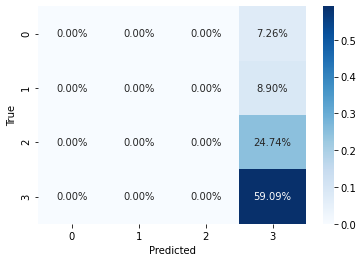

In [50]:
redsvm_cf_matrix = confusion_matrix(y_test_final, redsvm_best_predictions)
##CM with Percentages
redsvm_ax = sns.heatmap(redsvm_cf_matrix/np.sum(redsvm_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

print(redsvm_ax.set(xlabel='Predicted', ylabel='True'))

In [51]:
print(mae(y_test_final, redsvm_best_predictions))
print(zero_one_loss(y_test_final, redsvm_best_predictions))

0.6433642818132168
0.40906608410704537


<font size="6">
5.c Comparison of models

How to apply wilcoxon test:
1.  You need a list which values represent the differences between two groups.
2. In my case, that list should thus compare the error of one model with the error of another model, for every instance. HOW:
    a. make a column that shows error for every model. (example: error_ovo = abs(ovo_predicted - true)
    b. make a list that compares two of those columns. (example: differences = error_ovo - error_svmop).
    c. Now you have the list that compares the errors, as required by step 2. 
3. This list can be put into the wilcoxon test. The wilcoxon takes the list of differences and produces a statistic and p.value.

For example on other dataset see link.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

In [53]:
print(mae(y_test_final, ovo_gscv_predictions))
print(mae(true_scores, svmop_best_predictions))
print(mae(true_scores, svorex_best_predictions))
print(mae(true_scores, redsvm_best_predictions))

0.8994661096397649
0.6111414527580558
1.5019115237575096
0.6433642818132168


In [55]:
differences_ovo_svmop = list(ovo_gscv_predictions - svmop_best_predictions)
differences_ovo_svorex = list(ovo_gscv_predictions - svorex_best_predictions)
differences_ovo_redsvm = list(ovo_gscv_predictions - redsvm_best_predictions)
differences_svmop_svorex = list(svmop_best_predictions - svorex_best_predictions)
differences_svmop_redsvm = list(svmop_best_predictions - redsvm_best_predictions)
differences_svorex_redsvm = list(svmop_best_predictions - redsvm_best_predictions)

In [56]:
test_ovo_svmop = wilcoxon(differences_ovo_svmop)
print('ovo compared to svmop results: statistic is:', test_ovo_svmop.statistic, 
      'p is', test_ovo_svmop.pvalue)

test_ovo_svorex = wilcoxon(differences_ovo_svorex)
print('ovo compared to svorex results: statistic is:', test_ovo_svorex.statistic, 
      'p is', test_ovo_svorex.pvalue)

test_ovo_redsvm = wilcoxon(differences_ovo_redsvm)
print('ovo compared to redsvm results: statistic is:', test_ovo_redsvm.statistic, 
      'p is', test_ovo_redsvm.pvalue)

test_svmop_svorex = wilcoxon(differences_svmop_svorex)
print('svmop compared to svorex results: statistic is:', test_svmop_svorex.statistic, 
      'p is', test_svmop_svorex.pvalue)

test_svmop_redsvm = wilcoxon(differences_svmop_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svmop_redsvm.statistic, 
      'p is', test_svmop_redsvm.pvalue)

test_svorex_redsvm = wilcoxon(differences_svorex_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svorex_redsvm.statistic, 
      'p is', test_svorex_redsvm.pvalue)

ovo compared to svmop results: statistic is: 20679.0 p is 0.5943019805562519
ovo compared to svorex results: statistic is: 39483.0 p is 2.737591284058026e-257
ovo compared to redsvm results: statistic is: 0.0 p is 4.262525577237035e-147
svmop compared to svorex results: statistic is: 34944.0 p is 6.227198441131373e-261
svmop compared to redsvm results: statistic is: 0.0 p is 2.783856741829474e-164
svmop compared to redsvm results: statistic is: 0.0 p is 2.783856741829474e-164


error_ovo = abs(ovo_gscv_predictions - list_true_scores)
error_svmop = abs(svmop_best_predictions - list_true_scores)
error_svorex = abs(np.array(SVOREX_best_predictions) - np.array(list_true_scores))
error_redsvm = abs(np.array(REDSVM_best_predictions) - np.array(list_true_scores))


differences_error_ovo_svmop = list(error_ovo - error_svmop)
differences_error_ovo_svorex = list(error_ovo - error_svorex)
differences_error_ovo_redsvm = list(error_ovo - error_redsvm)
differences_error_svmop_svorex = list(error_svmop - error_svorex)
differences_error_svmop_redsvm = list(error_svmop - error_redsvm)
differences_error_svorex_redsvm = list(error_svorex - error_redsvm)

true_list = list(true_scores)


test_ovo_svmop = wilcoxon(differences_error_ovo_svmop)
print('ovo compared to svmop results: statistic is:', test_ovo_svmop.statistic, 
      'p is', test_ovo_svmop.pvalue)

test_ovo_svorex = wilcoxon(differences_error_ovo_svorex)
print('ovo compared to svorex results: statistic is:', test_ovo_svorex.statistic, 
      'p is', test_ovo_svorex.pvalue)

test_ovo_redsvm = wilcoxon(differences_error_ovo_redsvm)
print('ovo compared to redsvm results: statistic is:', test_ovo_redsvm.statistic, 
      'p is', test_ovo_redsvm.pvalue)

test_svmop_svorex = wilcoxon(differences_error_svmop_svorex)
print('svmop compared to svorex results: statistic is:', test_svmop_svorex.statistic, 
      'p is', test_svmop_svorex.pvalue)

test_svmop_redsvm = wilcoxon(differences_error_svmop_redsvm)
print('svmop compared to redsvm results: statistic is:', test_svmop_redsvm.statistic, 
      'p is', test_svmop_redsvm.pvalue)



<font size="6">
    6. Feature importance 

<font size="6"> 6.a. Using mutual information are suitable when the predictors include ordinal variables

In [58]:
fs_MI = SelectKBest(score_func=mutual_info_classif, k='all')
fs_MI.fit(X_train, y_train)
X_train_fs_MI = fs_MI.transform(X_train)
X_test_fs_MI = fs_MI.transform(X_test_final)

In [59]:
# what are scores for the features
feature_importance_scores_MI = []
for i in range(len(fs_MI.scores_)):
    scorelist_MI = print(fs_MI.scores_[i])

0.014993199359704334
0.003526443591201467
0.024183073870724714
0.006744306684474122
0.01986873269876477
0.0
0.012494971730173887
0.013679615903621434
0.0004771193953065911
0.0
0.01322895973620053
0.05919002034508569
0.0
0.0
0.0
0.0
0.005526535062831517
0.07176380612900668
0.044252369303363626
0.0
0.003077065233670684
0.0
0.006016582164516837
0.010550187396031419
0.0012541387605145005
0.01085149260749585
0.01415003186572994
0.0
0.00289359390922872
0.0025517799008629716
0.005847461922266817
0.03345469657365552
0.006565840311346438
0.042304335736330856
0.024801116669080248
0.028861417664214573
0.0157155626966059
0.0002777087747056761
0.033886446892928745
0.02217328020575926
0.0


In [70]:
for col in X_train:
    print(col)

agea
hinctnta
eisced
hhmmb
eduyrs
sclmeet
wrkhome
c19whome
wrklong
wrkresp
c19whacc
mansupp
manwrkpl
manspeak
manscrn
manphone
mancom
teamfeel
wrkextra
colprop
colspeak
colscrn
colphone
colcom
c19spwrk
c19mcwrk
mcwrkhom
uemp3m
uemp12m
uemp5yr
emplrel
hincfel
gndr
trdawrk
jbprtfp
pfmfdjba
dcsfwrka
c19wplch
manhlp
colhlp
colscrn


In [88]:
list = []
for i in range(len(fs_MI.scores_)):
    print(fs_MI.scores_)
print(list)

SyntaxError: invalid syntax (<ipython-input-88-1e0c4a9df657>, line 2)

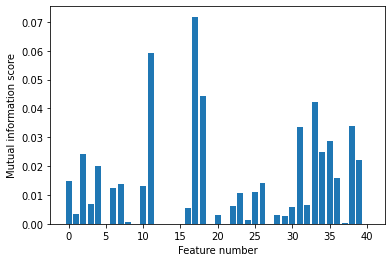

In [91]:
pyplot.bar([i for i in range(len(fs_MI.scores_))], (fs_MI.scores_))
pyplot.xlabel('Feature number')
pyplot.ylabel('Mutual information score')
pyplot.show()

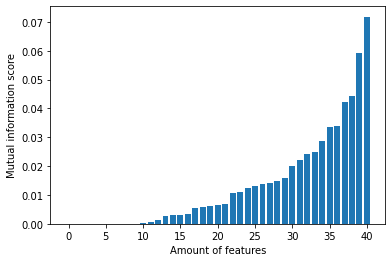

In [96]:
pyplot.bar([i for i in range(len(fs_MI.scores_))], sorted(fs_MI.scores_))
pyplot.xlabel('Amount of features')
pyplot.ylabel('Mutual information score')
pyplot.show()

<font size="6"> 6.b. Plot all relations with job satisfaction

In [62]:
df = df_final

Text(0, 0.5, 'Percentage')

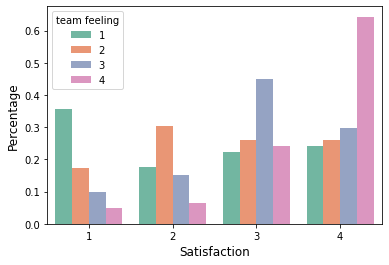

In [63]:
x, y, hue = "satisfaction", "proportion", "team feeling"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

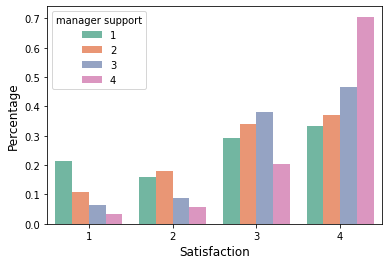

In [64]:
x, y, hue = "satisfaction", "proportion", "manager support"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

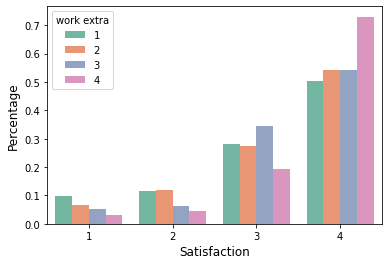

In [72]:
x, y, hue = "satisfaction", "proportion", "work extra"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

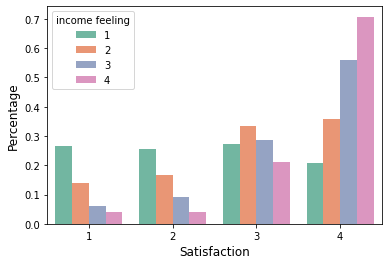

In [65]:
x, y, hue = "satisfaction", "proportion", "income feeling"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

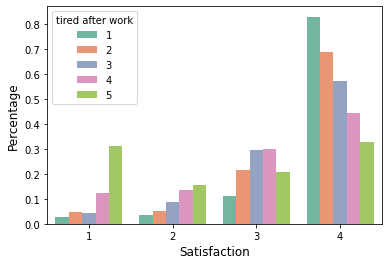

In [66]:
x, y, hue = "satisfaction", "proportion", "tired after work"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

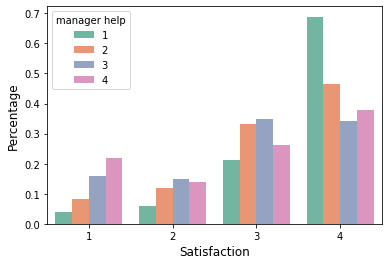

In [67]:
x, y, hue = "satisfaction", "proportion", "manager help"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

Text(0, 0.5, 'Percentage')

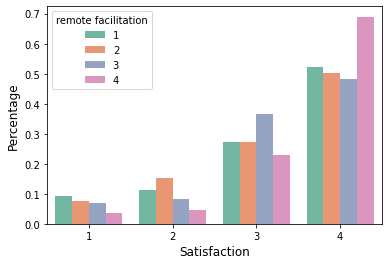

In [68]:
x, y, hue = "satisfaction", "proportion", "remote facilitation"
hue_order = ['satisfaction']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Satisfaction', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)

<font size="4">The plot below shows the relation between actual income decile and income feeling

Text(0, 0.5, 'Percentage')

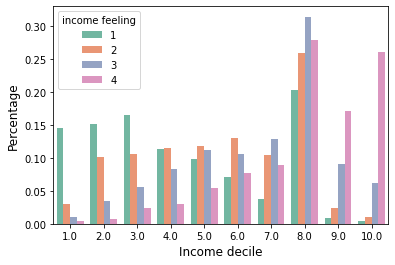

In [69]:
x, y, hue = "hinctnta", "proportion", "income feeling"
hue_order = ['hinctnta']

plot_country = (df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette = "Set2"))
plt.xlabel('Income decile', fontsize = 12)
plt.ylabel('Percentage', fontsize=12)